In [1]:
#Import Python modules for JupyterLite environment using piplite
import piplite
# await piplite.install("numpy")
# await piplite.install("scipy")
await piplite.install("plotly")
# await piplite.install("nbformat")
await piplite.install("ipywidgets")

In [2]:
#Uncomment the lines below to install required Python modules if running in a new JupyterLab Python install
# !pip install numpy
# !pip install pip install plotly
# !pip install nbformat>=4.2.0
# !pip install ipywidgets

In [3]:
import numpy as np #import array manipulation and maths library numpy under the alias np
import plotly.graph_objects as go #import our plotting library under the alias go
import ipywidgets as widgets #import our interactive widgets library under the alias widgets
from ipywidgets import interact,FloatSlider #for interactive sliders
from scipy.spatial.transform import Rotation as R #import SciPy rotation library under the alias R for Euler angle rotations
# from IPython.display import Latex, display #for python to display latex math

In [4]:
# #set the plotly graphing library to use the jupyterlab one
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"

In [5]:
from astropy import units as u #import the astropy units package so we can use real world units conveniently

class Earth:
    """Earth class with useful atributes, used as poliastro is not available in JupyterLite"""
    #radius
    #source:
    #Archinal, B.A. et al. "Report of the IAU working group on cartographic coordinates and rotational elements: 2015"
    #Celestial Mechanics and Dynamical Astronomy 109(2011): 101-135.
    #DOI: https://doi.org/10.1007/s10569-010-9320-4
    R =  6371.0084*u.km
    
    #gravitational parameter GM
    #source:
    #Luzum, Brian et al. “The IAU 2009 System of Astronomical Constants: The Report of the IAU Working Group on Numerical Standards for Fundamental Astronomy."
    #Celestial Mechanics and Dynamical Astronomy 110.4 (2011): 293–304.
    #DOI: https://doi.org/10.1007/s10569-011-9352-4
    k = 3.986004418e14*u.m**3/u.s**2

class Moon:
    """Moon class with useful atributes, used as poliastro is not available in JupyterLite"""
    #radius
    #source:
    #Archinal, B.A. et al. "Report of the IAU working group on cartographic coordinates and rotational elements: 2015"
    #Celestial Mechanics and Dynamical Astronomy 109(2011): 101-135.
    #DOI: https://doi.org/10.1007/s10569-010-9320-4
    R = 1737.1*u.km #mean radius
    
    #gravitational parameter GM
    #source:
    #Lemoine, Frank G. et al. “High-Degree Gravity Models from GRAIL Primary Mission Data.”
    #Journal of Geophysical Research: Planets 118.8 (2013): 1676–1698.
    #DOI: https://doi.org/10.1002/jgre.20118
    k = 4.90279981e12*u.m**3/u.s**2

In [6]:
sma_initial = (Earth.R+500*u.km).to(u.km).value
ecc_initial = 0
inc_initial = 0

orbit_res = 50 #number of points used to plot ellipse
body_res = 30 #numbe or points to use in meshgrid creation
box_scale = 6 #viebox cube sidelengt in Earth radii

def sphere3d(x_0, y_0, z_0, r, res):
    """Sphere surface creation function for use with Plotly go.Surface"""
    phi, theta = np.mgrid[0:np.pi:res*1j, 0:2*np.pi:res*1j] # create a meshgrid with 100 values for phi and 100 values for theta
    xs = x_0+r*np.sin(theta)*np.cos(phi)
    ys = y_0+r*np.sin(theta)*np.sin(phi)
    zs = z_0+r*np.cos(theta)
    
    return xs, ys, zs

def ellipse3d(sma, ecc, inc, res):
    """Ellipse line creation function for use with Plotly go.Scatter3d"""
    theta = np.linspace(0, 2*np.pi, res)
    
    #create ellipse points on a 2d plane
    ellipse_xs = sma*np.cos(theta)-sma*ecc
    ellipse_ys = sma*np.sqrt(1-ecc**2)*np.sin(theta)
    ellipse_zs = 0*theta
    
    #prepare datapoints for rotation matrix multiplication
    #source: https://community.plotly.com/t/controlling-animation-speed-using-graph-objects-in-python/41038/21
    m = ellipse_xs.shape
    xyz = np.vstack((ellipse_xs.flatten(),ellipse_ys.flatten(),ellipse_zs.flatten()))
    
    r = R.from_euler("x", inc).as_matrix() #create rotation matrix for inclination rotation
    
    
    xyz_rotated = r @ xyz #apply rotation via matrix multiplication
    xs, ys, zs = xyz_rotated[0].reshape(m), xyz_rotated[1].reshape(m), xyz_rotated[2].reshape(m)
    
    return xs, ys, zs

#create a scatter plot from the x and y arrays
fig = go.FigureWidget()

fig.layout.template = "plotly_dark" #change plotly theme to dark mode

#update figure layout as needed
fig.update_layout(title_text="3D Orbit Plot", #set figure title
    #set height & activate width autosize
    height=800,
    autosize=True,
    # showlegend=False,
    scene=dict(
        #specify the aspect ratio as 1:1:1 to avoid squished objects after we set set the bounds
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1),
        #set the view box size
        xaxis=dict(nticks=8, range=[-box_scale/2*Earth.R.to(u.km).value,box_scale/2*Earth.R.to(u.km).value],),
        yaxis=dict(nticks=8, range=[-box_scale/2*Earth.R.to(u.km).value,box_scale/2*Earth.R.to(u.km).value],),
        zaxis=dict(nticks=8, range=[-box_scale/2*Earth.R.to(u.km).value,box_scale/2*Earth.R.to(u.km).value],),
        #set axes titles
        xaxis_title="X Axis (km)",
        yaxis_title="Y Axis (km)",
        zaxis_title="Z Axis (km)"))

body_xs, body_ys, body_zs = sphere3d(0, 0, 0, Earth.R.to(u.km).value, body_res) #create the body sphere surface
fig.add_trace(go.Surface(x=body_xs, y=body_ys, z=body_zs, showscale=False)) #add the body to the graph

orbit_xs, orbit_ys, orbit_zs = ellipse3d(sma_initial, ecc_initial, inc_initial, orbit_res)

#add the orbit ellipse to the graph
fig.add_trace(go.Scatter3d(x=orbit_xs, y=orbit_ys, z = orbit_zs, mode="lines", name="Orbit")) #add line to graph


#update function for graph
def update(sma,ecc,inc):
    with fig.batch_update():
        orbit_xs, orbit_ys, orbit_zs = ellipse3d(sma, ecc, inc, orbit_res)
        fig.data[1].x = orbit_xs
        fig.data[1].y = orbit_ys
        fig.data[1].z = orbit_zs
        fig.data[1].name = "Orbit: a = {}, e = {}, i = {}".format(sma,ecc,inc)

layout = widgets.Layout(width="600px") #make the widgets wider so the slider bars are bigger

#create the slider widgets and link up with the callback function that updates the graph        
interact(update,
    sma=FloatSlider(
        min=1000,
        max=30000,
        step=3,
        readout_format=".0f",
        value=sma_initial,
        description="sma (km)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
    ecc=FloatSlider(
        min=0,
        max=1,
        step=0.01,
        readout_format=".2f",
        value=ecc_initial,
        description="ecc",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
     inc=FloatSlider(
        min=0,
        max=np.pi,
        step=0.01,
        readout_format=".2f",
        value=inc_initial,
        description="inc (rad)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
);

fig #diplay the interactive plot widget

interactive(children=(FloatSlider(value=6871.0084, description='sma (km)', layout=Layout(width='600px'), max=3…

FigureWidget({
    'data': [{'showscale': False,
              'type': 'surface',
              'uid': '23c69315-b62a-4281-80f4-c9c8dcb5c84c',
              'x': array([[ 0.00000000e+00,  1.36957848e+03,  2.67511699e+03, ...,
                           -2.67511699e+03, -1.36957848e+03, -1.56044701e-12],
                          [ 0.00000000e+00,  1.36154995e+03,  2.65943534e+03, ...,
                           -2.65943534e+03, -1.36154995e+03, -1.55129960e-12],
                          [ 0.00000000e+00,  1.33755850e+03,  2.61257424e+03, ...,
                           -2.61257424e+03, -1.33755850e+03, -1.52396462e-12],
                          ...,
                          [ 0.00000000e+00, -1.33755850e+03, -2.61257424e+03, ...,
                            2.61257424e+03,  1.33755850e+03,  1.52396462e-12],
                          [ 0.00000000e+00, -1.36154995e+03, -2.65943534e+03, ...,
                            2.65943534e+03,  1.36154995e+03,  1.55129960e-12],
                

## Rotation Code
Source: https://community.plotly.com/t/rotating-3d-plots-with-plotly/34776/

In [14]:
import piplite
await piplite.install("dash")
# await piplite.install("setuptools")
await piplite.install("plotly==5.15.0")
await piplite.install("nbformat>=4.2.0")

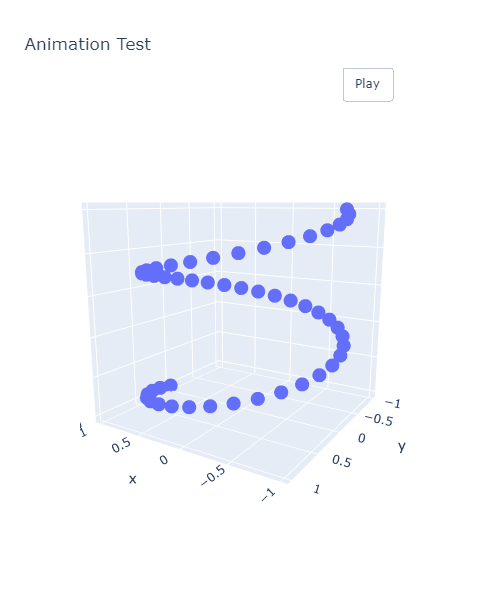

In [15]:
import plotly.graph_objects as go
import plotly
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

fig= go.Figure(go.Scatter3d(x=x, y=y, z=z, mode='markers'))

x_eye = -1.25
y_eye = 2
z_eye = 0.5

fig.update_layout(
         title='Animation Test',
         width=600,
         height=600,
         scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
         updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=1,
                  x=0.8,
                  xanchor='left',
                  yanchor='bottom',
                  pad=dict(t=45, r=10),
                  buttons=[dict(label='Play',
                                 method='animate',
                                 args=[None, dict(frame=dict(duration=10, redraw=True), 
                                                             transition=dict(duration=0),
                                                             fromcurrent=True,
                                                             mode='immediate'
                                                            )]
                                            )
                                      ]
                              )
                        ]
)


def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

frames=[]
for t in np.arange(0, 6.26, 0.005):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames=frames

fig